In [1]:
%load_ext autoreload
%autoreload 2

In [135]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.spatial.transform import Rotation as R


from AdjQuat import utils
from AdjQuat import simulators
from AdjQuat import solutions
from AdjQuat.procrustes_wasserstein import procrustes_wasserstein_2d_3d_dram, procrustes_wasserstein_2d_3d_svd

## 1. Data generation

First we will set up our data generation process.

In [528]:
# We define a manual seed for reproducilibity.
torch.manual_seed(0)

In [529]:
# First we generate random points in 3D space
npts = 50
xyz = torch.randn(npts, 3, dtype=torch.double)

In [530]:
xyz[0] # just to check our first point is the same for different runs

tensor([-2.3104, -0.3733, -1.0608], dtype=torch.float64)

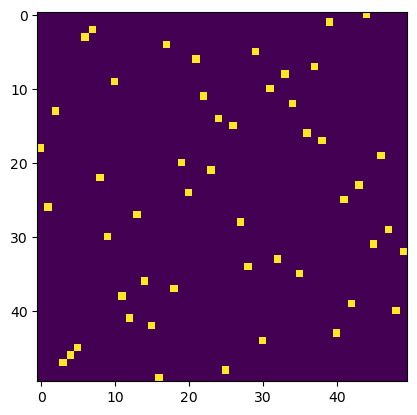

In [531]:
# Create a permutation matrix
torch.manual_seed(0)
permutation_idx = torch.randperm(npts)
permutation_matrix = torch.zeros(npts,npts, dtype=torch.double)
permutation_matrix[torch.arange(npts), permutation_idx] = 1
plt.imshow(permutation_matrix)

In [532]:
xyz_permuted = torch.matmul(permutation_matrix, xyz)

# 2. Find ordering in 3d -> 3d problem with no misrotation

In [533]:
C = torch.cdist(xyz,xyz_permuted, p=2) ** 2

In [534]:
p = q = np.ones(npts)
transport_plan, log = ot.emd(p, q, C.numpy(), log=True)

In [535]:
np.allclose(permutation_matrix.T, transport_plan)

True

In [536]:
np.allclose(xyz_permuted.numpy(), transport_plan.T @ xyz.numpy())

True

# 3. optimize rotation

Start with a slightly rotated and permuted point cloud xyz_permuted_rotated and the projection along z before rotation and permuting

/tmp/ipykernel_2434601/1587677271.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xyz_permuted_rotated = xyz[permutation_idx] @ rotation


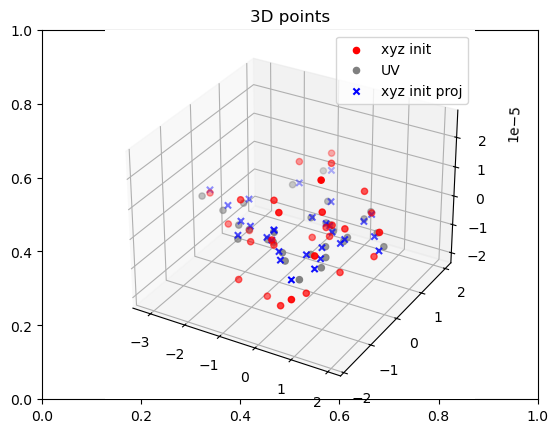

In [167]:
torch.manual_seed(0)

npts = 30
xyz = torch.randn(npts, 3, dtype=torch.double)
xyz[:,2] = torch.randn(npts, dtype=torch.double) * 0.00001
UV = xyz[:,:2] + torch.randn(npts, 2, dtype=torch.double) * 0.00001

permutation_idx = torch.arange(npts)
k_permute = 2
permutation_idx[:k_permute] = torch.randperm(k_permute)
#torch.randperm(npts)
rotation = R.from_euler('zyz', [5,0,0], degrees=True).as_matrix()
xyz_permuted_rotated = xyz[permutation_idx] @ rotation
xyz_init = xyz_permuted_rotated.clone()

# plot

fig, ax = plt.subplots(1,1)

ax2 = fig.add_subplot(1,1,1, projection='3d')
ax2.scatter(xs=xyz_init[:, 0], ys=xyz_init[:, 1], zs=xyz_init[:, 2], label='xyz init', marker='o', color='red')
ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray')
ax2.scatter(xs=xyz_init[:, 0], ys=xyz_init[:, 1], zs=0, label='xyz init proj', marker='x', color='blue')
ax2.set_title('3D points')
ax2.legend()

Compute cost between UV and xyz rotated (2D cost with xyz projected)

{'cost': 3.517732561940898,
 'u': array([0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.04946202, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.03731092, 0.05971762, 0.05971762, 0.05971762]),
 'v': array([ 0.05668473,  0.14444308,  0.03340058,  0.07616579,  0.08613826,
        -0.02731371,  0.06726215, -0.03571512,  0.04125491,  0.09179827,
         0.02729534, -0.01117354,  0.08769146,  0.03920289,  0.13182742,
         0.05980931,  0.21484447,  0.01768075,  0.05456157,  0.11959058,
         0.02125548,  0.03874367,  0.02767949,  0.1150419 ,  0.02193105,
         0.10074295,  0.04089629,  0.03744013,  0.11197712, -0.032291  ]),
 'warning': None,
 'result_code': 1}

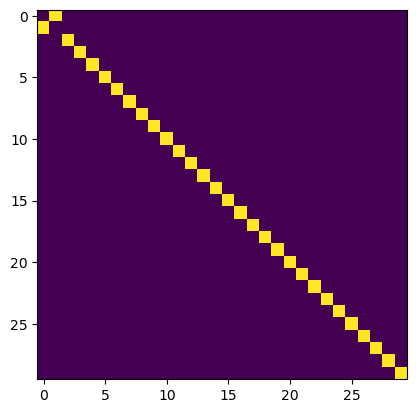

In [168]:
cost = torch.cdist(UV, xyz_permuted_rotated[:,:2], p=2)
p = q = np.ones(npts)
transport_plan, log = ot.emd(p, q, cost.numpy(), log=True)
plt.imshow(transport_plan)
log

In [169]:
xyz_permuted_unpermuted = torch.from_numpy(transport_plan) @ xyz_init
xyz_permuted_unpermuted

tensor([[-2.3342e+00, -1.7046e-01, -6.4547e-06],
        [ 9.1866e-01, -9.6777e-01,  2.5724e-05],
        [-6.9637e-01, -8.0883e-01, -2.0245e-05],
        [ 1.5460e+00,  1.8964e-01, -6.8301e-06],
        [ 1.0245e+00, -1.3212e+00,  4.3130e-06],
        [ 3.5011e-01,  1.2347e-01, -3.6563e-06],
        [-1.3195e+00, -6.1429e-01, -5.3123e-06],
        [ 2.2494e-01,  1.5819e-01, -1.3408e-06],
        [ 9.8619e-01, -3.2989e-01, -9.8851e-06],
        [-1.6490e+00, -5.4536e-01,  7.2555e-06],
        [-5.2437e-01, -8.4853e-01,  8.1991e-08],
        [ 5.5338e-01, -5.7897e-02,  2.3697e-06],
        [-1.3582e+00, -1.0050e+00, -1.5195e-05],
        [ 9.7970e-01,  5.7071e-01,  1.0216e-05],
        [-9.7852e-01,  1.9655e+00,  6.0316e-06],
        [ 1.2171e-01, -1.3646e+00, -1.5447e-05],
        [-3.1432e+00,  1.6083e-01, -1.0950e-06],
        [-7.1385e-01, -5.2701e-01,  1.0134e-05],
        [ 9.8317e-01,  8.6544e-01,  5.2988e-07],
        [-2.0428e+00,  2.2648e-01, -1.0986e-05],
        [-1.9672e-01

Permute points, and find optimal rotation given this ordering

In [170]:
rotation_new = solutions.make_R_tilde(xyz_permuted_unpermuted.numpy(),UV.numpy())
rotation_new_bi = solutions.make_M_opt_rot(xyz_permuted_unpermuted.numpy(),UV.numpy())

U,S,Vh = np.linalg.svd(rotation_new)
rotation_new, rotation, U@Vh, rotation_new_bi

(array([[ 0.99619698, -0.08715363, -0.25568683],
        [ 0.08715753,  0.99619514, -0.22591303],
        [ 0.27440312,  0.20276884,  1.00000269]]),
 array([[ 0.9961947 , -0.08715574,  0.        ],
        [ 0.08715574,  0.9961947 ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.96390742, -0.11101399, -0.24198838],
        [ 0.05862786,  0.9751144 , -0.21380991],
        [ 0.25970224,  0.1919057 ,  0.94642852]]),
 array([[ 0.96390742, -0.11101399, -0.24198838],
        [ 0.05862786,  0.9751144 , -0.21380991],
        [ 0.25970224,  0.1919057 ,  0.94642852]]))

In [171]:
torch.allclose((xyz_permuted_unpermuted @ rotation.T)[:, :2], UV, atol=1e-3)

/tmp/ipykernel_2434601/2424785271.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.allclose((xyz_permuted_unpermuted @ rotation.T)[:, :2], UV, atol=1e-3)


True

In [172]:
torch.allclose((xyz_permuted_unpermuted @ rotation_new.T)[:, :2], UV, atol=1e-4)

/tmp/ipykernel_2434601/4215844760.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.allclose((xyz_permuted_unpermuted @ rotation_new.T)[:, :2], UV, atol=1e-4)


True

In [173]:
torch.allclose((xyz_permuted_unpermuted @ (U@Vh).T)[:, :2], UV, atol=3e-1)

/tmp/ipykernel_2434601/2091390297.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.allclose((xyz_permuted_unpermuted @ (U@Vh).T)[:, :2], UV, atol=3e-1)


True

Proceed another iteration, updating the points with the rotation

/tmp/ipykernel_2434601/2192762385.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xyz_permuted_rotated = xyz_init @ rotation_new.T


{'cost': 0.00040105434879590587,
 'u': array([6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06]),
 'v': array([ 2.82850393e-06,  6.14437121e-06,  2.44956495e-06,  9.89772055e-06,
         1.38528481e-05,  1.22293161e-05,  3.93170617e-06,  7.27393049e-06,
         1.39254760e-06,  1.48534880e-06,  1.37555752e-07, -2.68999350e-07,
         5.70942486e-06,  2.43581930e-06,  1.72085078e-05,  6.42286326e-06,
         7.97032370e-06,  1.01346507e-05,  9.45546574e-06,  3.47087759e-06,
         5.03409122e-06,  4.600

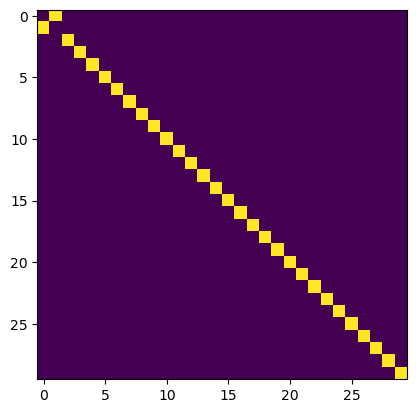

In [174]:
xyz_permuted_rotated = xyz_init @ rotation_new.T

cost = torch.cdist(UV, xyz_permuted_rotated[:,:2], p=2)
p = q = np.ones(npts)
transport_plan, log = ot.emd(p, q, cost.numpy(), log=True)
plt.imshow(transport_plan)
log

In [175]:
transport_plan, rotation, logs = procrustes_wasserstein_2d_3d_dram(xyz_init, UV, verbose_log=True, cost_d=2, tol=-np.inf, max_iter=2)

In [176]:
rotation = torch.from_numpy(R.from_euler('zyz', [5,5,5], degrees=True).as_matrix())
Rxy = rotation[:,:2]
U, S, Vh = torch.linalg.svd(Rxy, full_matrices=True)

Rxy_est = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_est[:,0],Rxy_est[:,1])
R_est = torch.cat([Rxy_est, Rz_est.reshape(3,1)], 1)
torch.allclose(rotation, R_est)
# U[:,:2].shape, S.shape, Vh.shape

True

# `procrustes_wasserstein_2d_3d_dram` function

In [556]:
torch.manual_seed(0)

npts = 20
xyz = torch.randn(npts, 3, dtype=torch.double)
xyz[:,2] = torch.randn(npts, dtype=torch.double) * 0.3
UV = xyz[:,:2] + torch.randn(npts, 2, dtype=torch.double) * 0.00001

permutation_idx = torch.arange(npts)
k_permute = npts
permutation_idx[:k_permute] = torch.randperm(k_permute)
rotation_gt = R.from_euler('zyz', [10,0,0], degrees=True).as_matrix()
xyz_permuted_rotated = xyz[permutation_idx] @ rotation_gt
xyz_init = xyz_permuted_rotated.clone()


/tmp/ipykernel_2434601/2319644827.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xyz_permuted_rotated = xyz[permutation_idx] @ rotation_gt


In [557]:
utils.least_squares_4_3D(np.eye(3), xyz.numpy(),UV.numpy())

np.float64(3.306678949570286e-09)

In [558]:
transport_plan, rotation, logs = procrustes_wasserstein_2d_3d_dram(xyz_init, UV, verbose_log=True, cost_d=2, tol=1e-6, max_iter=30)
logs

[{'cost': 1.3702696131107717,
  'u': array([ 0.28765358,  0.01852348, -0.00652016,  0.01852348,  0.01852348,
          0.01852348, -0.01162773,  0.01852348,  0.01852348, -0.00599645,
          0.01852348,  0.01852348,  0.01852348,  0.01852348,  0.01852348,
          0.01852348,  0.14377334,  0.01852348,  0.01852348,  0.01852348]),
  'v': array([ 0.09765349,  0.12795287,  0.07599786, -0.00881124,  0.0411331 ,
          0.06640884,  0.05519284,  0.03558204, -0.10478609,  0.02053295,
          0.01170983, -0.01748708, -0.00911751,  0.06820959,  0.00288005,
         -0.12122724, -0.01622713, -0.01433623,  0.35953956,  0.01433432]),
  'warning': None,
  'result_code': 1,
  'transport_plan': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
    

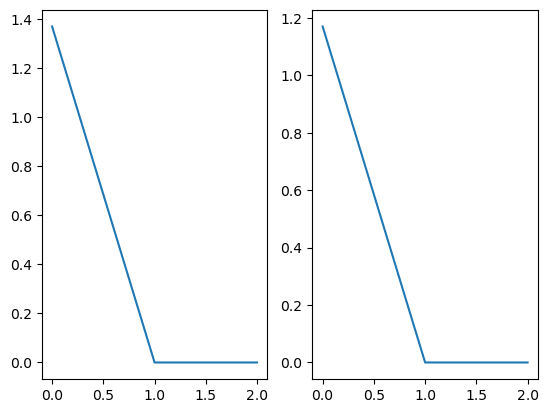

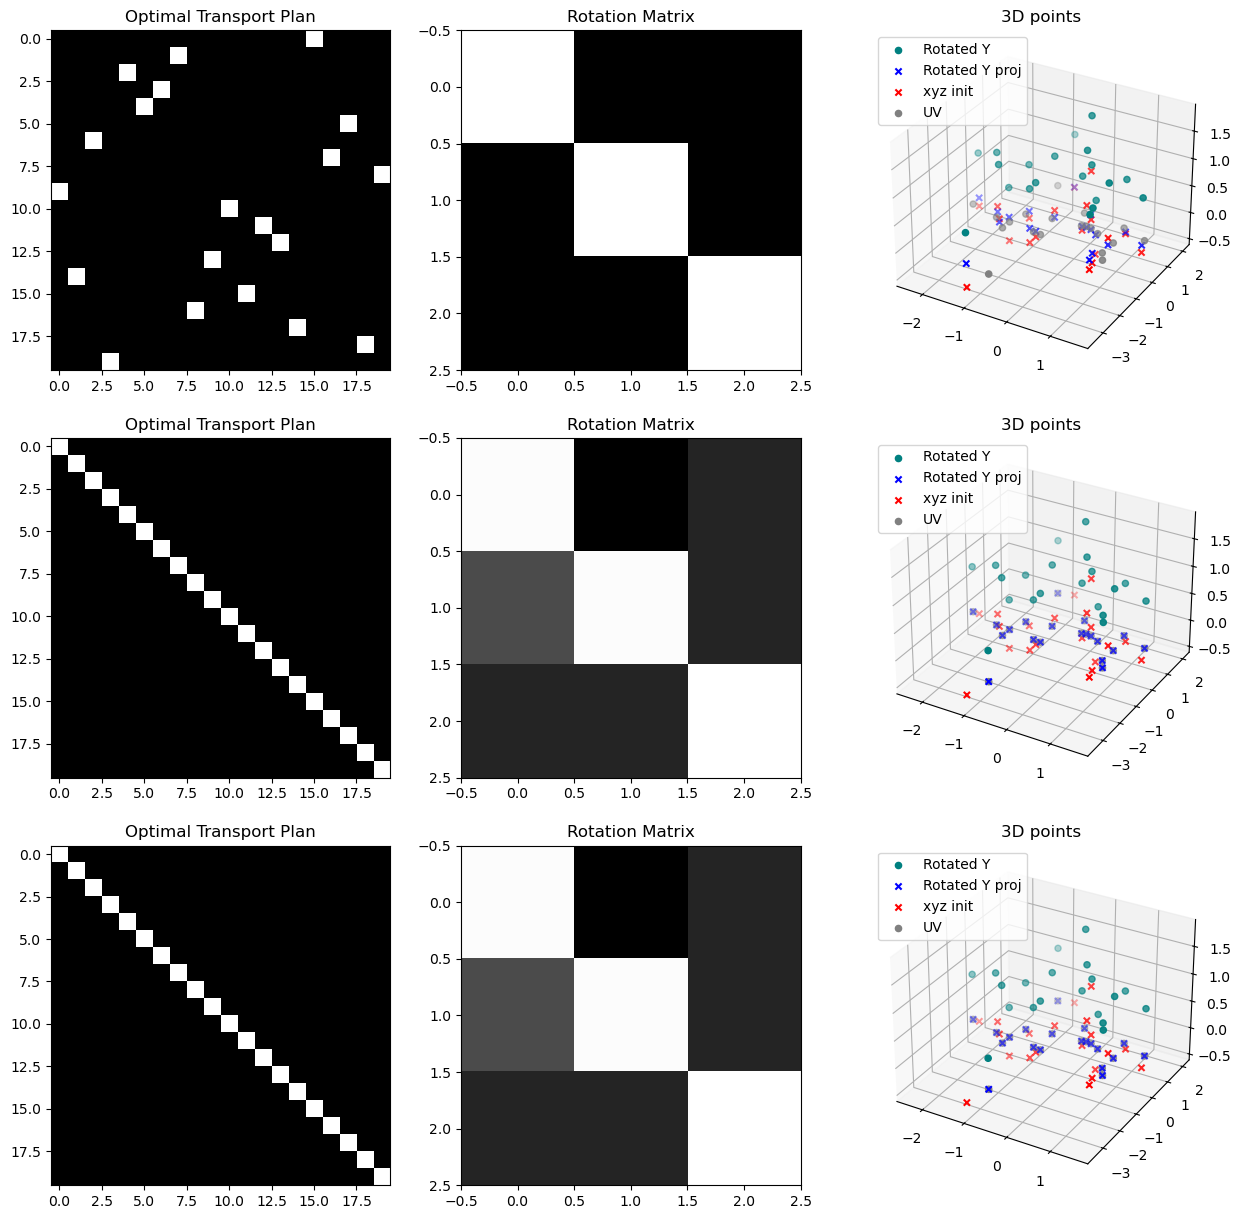

In [559]:
n_pl = min(10, len(logs))
X = UV.numpy()
transport_plans = [log['transport_plan'] for log in logs[:n_pl]]
Ps = [log['R'] for log in logs[:n_pl]]
YpRs = [log['xyz_permuted_R'] for log in logs[:n_pl]]

fig, axes = plt.subplots(1,2)
axes[0].plot([log['cost'] for log in logs], label='EMD')
axes[1].plot([log['point_norm'] for log in logs], label='point norm')
plt.show()


# plot these three
fig, axes = plt.subplots(n_pl, 3, figsize=(15, 5*n_pl), )
for idx in range(len(transport_plans)):
    axes[idx, 0].imshow(transport_plans[idx], cmap='gray')
    axes[idx,0].set_title('Optimal Transport Plan')
    axes[idx,1].imshow(Ps[idx], cmap='gray')
    axes[idx,1].set_title('Rotation Matrix')

    axes[idx, 2].remove()

    # Rotated Y with X in 3D
    ax2 = fig.add_subplot(n_pl, 3, 3 * idx + 3, projection='3d')
    ax2.scatter(xs=YpRs[idx][:, 0], ys=YpRs[idx][:, 1], zs=YpRs[idx][:, 2]+1, label='Rotated Y', marker='o', color='teal')
    ax2.scatter(xs=YpRs[idx][:, 0], ys=YpRs[idx][:, 1], zs=0, label='Rotated Y proj', marker='x', color='blue')
    ax2.scatter(xs=xyz_permuted_rotated[:, 0], ys=xyz_permuted_rotated[:, 1], zs=xyz_permuted_rotated[:, 2], label='xyz init', marker='x', color='red')
    ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray')
    ax2.set_title('3D points')
    ax2.legend()






# `procrustes_wasserstein_2d_3d_svd` 

## walk thorugh

We want to recover this rotation and ordering

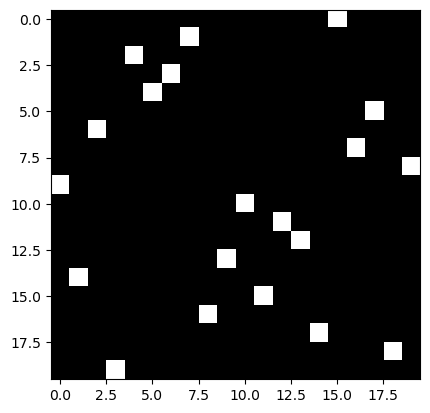

In [560]:
inverse_permutation_idx = torch.argsort(permutation_idx)
transport_plan_gt = torch.zeros(npts,npts)
transport_plan_gt[torch.arange(npts), inverse_permutation_idx] = 1
plt.imshow(transport_plan_gt, cmap='gray')

In [561]:
np.allclose((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2], xyz[:,:2]) 

/tmp/ipykernel_2434601/2607192233.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.allclose((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2], xyz[:,:2])


True

In [562]:
np.linalg.norm((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2] - UV.numpy()) 

/tmp/ipykernel_2434601/3987034288.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2] - UV.numpy())


np.float64(5.752983459429643e-05)

### round 1

Calculate cost between points

In [563]:
cost = torch.cdist(UV, xyz_init[:,:2], p=2)**2

Solve transport problem to find correspondence

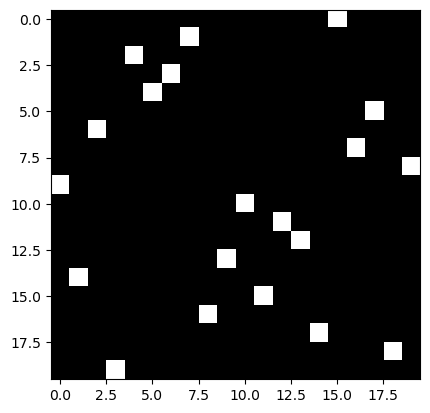

In [564]:
p = q = torch.ones(npts)
transport_plan, log = ot.emd(p.numpy(), q.numpy(), cost.numpy(), log=True)
plt.imshow(transport_plan, cmap='gray')
assert np.allclose(transport_plan_gt, transport_plan)

Estimate rotation that matches them with svd

In [565]:
Rxy_estimate = xyz_init.T @ transport_plan.T @ UV
Rxy_estimate, rotation_gt

/tmp/ipykernel_2434601/3996916833.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rxy_estimate = xyz_init.T @ transport_plan.T @ UV


(tensor([[22.2016,  7.7453],
         [-0.0858, 22.2111],
         [ 0.6135,  3.1590]], dtype=torch.float64),
 array([[ 0.98480775, -0.17364818,  0.        ],
        [ 0.17364818,  0.98480775,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

Project to Steifel and fill out missing column

In [566]:
U, _, Vh = torch.linalg.svd(Rxy_estimate, full_matrices=True)
Rxy_projected = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)
rotation_new


tensor([[ 0.9849,  0.1710, -0.0279],
        [-0.1732,  0.9761, -0.1312],
        [ 0.0048,  0.1341,  0.9910]], dtype=torch.float64)

In [567]:
Rxy_projected = Rxy_estimate
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new_ = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)

U, _, Vh = torch.linalg.svd(rotation_new_, full_matrices=True)
rotation_new_ = U @ Vh

torch.allclose(rotation_new_, rotation_new)


True

Let's rotate the xyz point cloud and check how much closer the projection is. Note that to compoute this, we need a transport plan for correspondence. If we estimate it well, then the norm (which demands a correspondence of points) will be small.

In [568]:
np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy()) 

/tmp/ipykernel_2434601/3162566192.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy())


np.float64(0.15436267946518453)

### round 2

Using this new rotation, we recompute the cost

In [569]:
cost = torch.cdist(UV, (xyz_init @ rotation_new)[:,:2], p=2)**2

And we recompute the transport plan

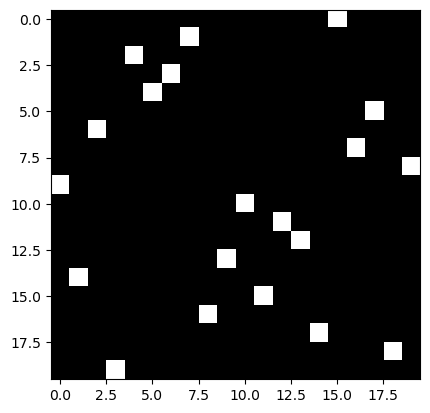

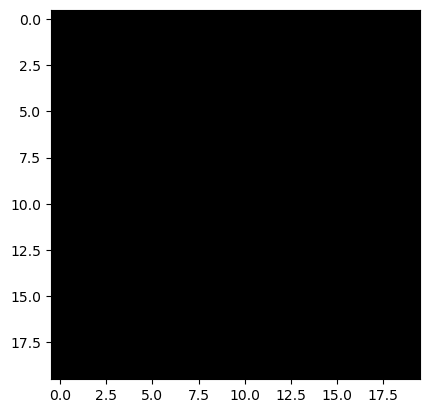

In [570]:
transport_plan, log = ot.emd(p.numpy(), q.numpy(), cost.numpy(), log=True)
plt.imshow(transport_plan, cmap='gray')
plt.show()
plt.imshow(transport_plan-transport_plan_gt.numpy(), cmap='gray')

Steifel and SO(3)

In [571]:
Rxy_estimate = xyz_init.T @ transport_plan.T @ UV
Rxy_estimate, rotation_gt

/tmp/ipykernel_2434601/3996916833.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rxy_estimate = xyz_init.T @ transport_plan.T @ UV


(tensor([[22.2016,  7.7453],
         [-0.0858, 22.2111],
         [ 0.6135,  3.1590]], dtype=torch.float64),
 array([[ 0.98480775, -0.17364818,  0.        ],
        [ 0.17364818,  0.98480775,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

In [572]:
U, _, Vh = torch.linalg.svd(Rxy_estimate, full_matrices=True)
Rxy_projected = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)
rotation_new

tensor([[ 0.9849,  0.1710, -0.0279],
        [-0.1732,  0.9761, -0.1312],
        [ 0.0048,  0.1341,  0.9910]], dtype=torch.float64)

Depending on how good the new transport plan and rotation matrix are, the projected points may now be closer

In [573]:
np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy()) 

/tmp/ipykernel_2434601/3162566192.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy())


np.float64(0.15436267946518453)

### round 3

In [574]:
cost = torch.cdist(UV, (xyz_init @ rotation_new)[:,:2], p=2)**2

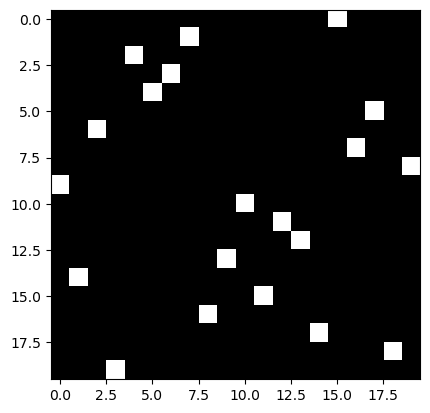

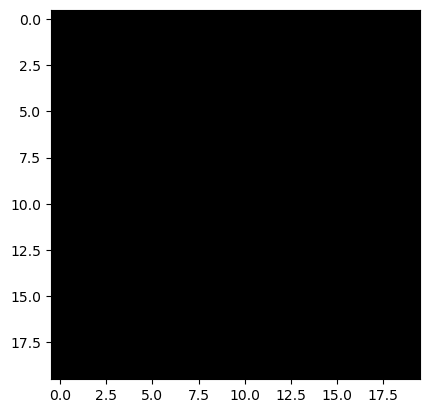

In [575]:
transport_plan, log = ot.emd(p.numpy(), q.numpy(), cost.numpy(), log=True)
plt.imshow(transport_plan, cmap='gray')
plt.show()
plt.imshow(transport_plan-transport_plan_gt.numpy(), cmap='gray')

In [576]:
Rxy_estimate = xyz_init.T @ transport_plan.T @ UV
Rxy_estimate, rotation_gt

/tmp/ipykernel_2434601/3996916833.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rxy_estimate = xyz_init.T @ transport_plan.T @ UV


(tensor([[22.2016,  7.7453],
         [-0.0858, 22.2111],
         [ 0.6135,  3.1590]], dtype=torch.float64),
 array([[ 0.98480775, -0.17364818,  0.        ],
        [ 0.17364818,  0.98480775,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

In [577]:
U, _, Vh = torch.linalg.svd(Rxy_estimate, full_matrices=True)
Rxy_projected = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)
rotation_new

tensor([[ 0.9849,  0.1710, -0.0279],
        [-0.1732,  0.9761, -0.1312],
        [ 0.0048,  0.1341,  0.9910]], dtype=torch.float64)

In [578]:
np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy()) 

/tmp/ipykernel_2434601/3162566192.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy())


np.float64(0.15436267946518453)

## function

In [579]:
transport_plan, rotation, logs = procrustes_wasserstein_2d_3d_svd(UV, xyz_init, p=torch.ones(npts), q=torch.ones(npts), verbose_log=True, tol=1e-6, max_iter=30)
logs

shapes torch.Size([3, 3]) torch.Size([2, 2])
shapes torch.Size([3, 3]) torch.Size([2, 2])
shapes torch.Size([3, 3]) torch.Size([2, 2])


[{'cost': 1.3702696131107717,
  'u': array([ 0.28765357,  0.01852348, -0.00652016,  0.01852348,  0.01852348,
          0.01852348, -0.01162773,  0.01852348,  0.01852348, -0.00599645,
          0.01852348,  0.01852348,  0.01852348,  0.01852348,  0.01852348,
          0.01852348,  0.14377333,  0.01852348,  0.01852348,  0.01852348],
        dtype=float32),
  'v': array([ 0.09765349,  0.12795287,  0.07599787, -0.00881124,  0.04113309,
          0.06640884,  0.05519284,  0.03558204, -0.10478609,  0.02053295,
          0.01170983, -0.01748708, -0.00911751,  0.06820959,  0.00288005,
         -0.12122724, -0.01622713, -0.01433623,  0.35953957,  0.01433432],
        dtype=float32),
  'warning': None,
  'result_code': 1,
  'transport_plan': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

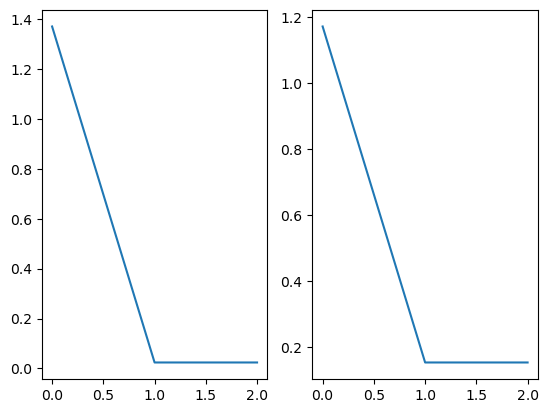

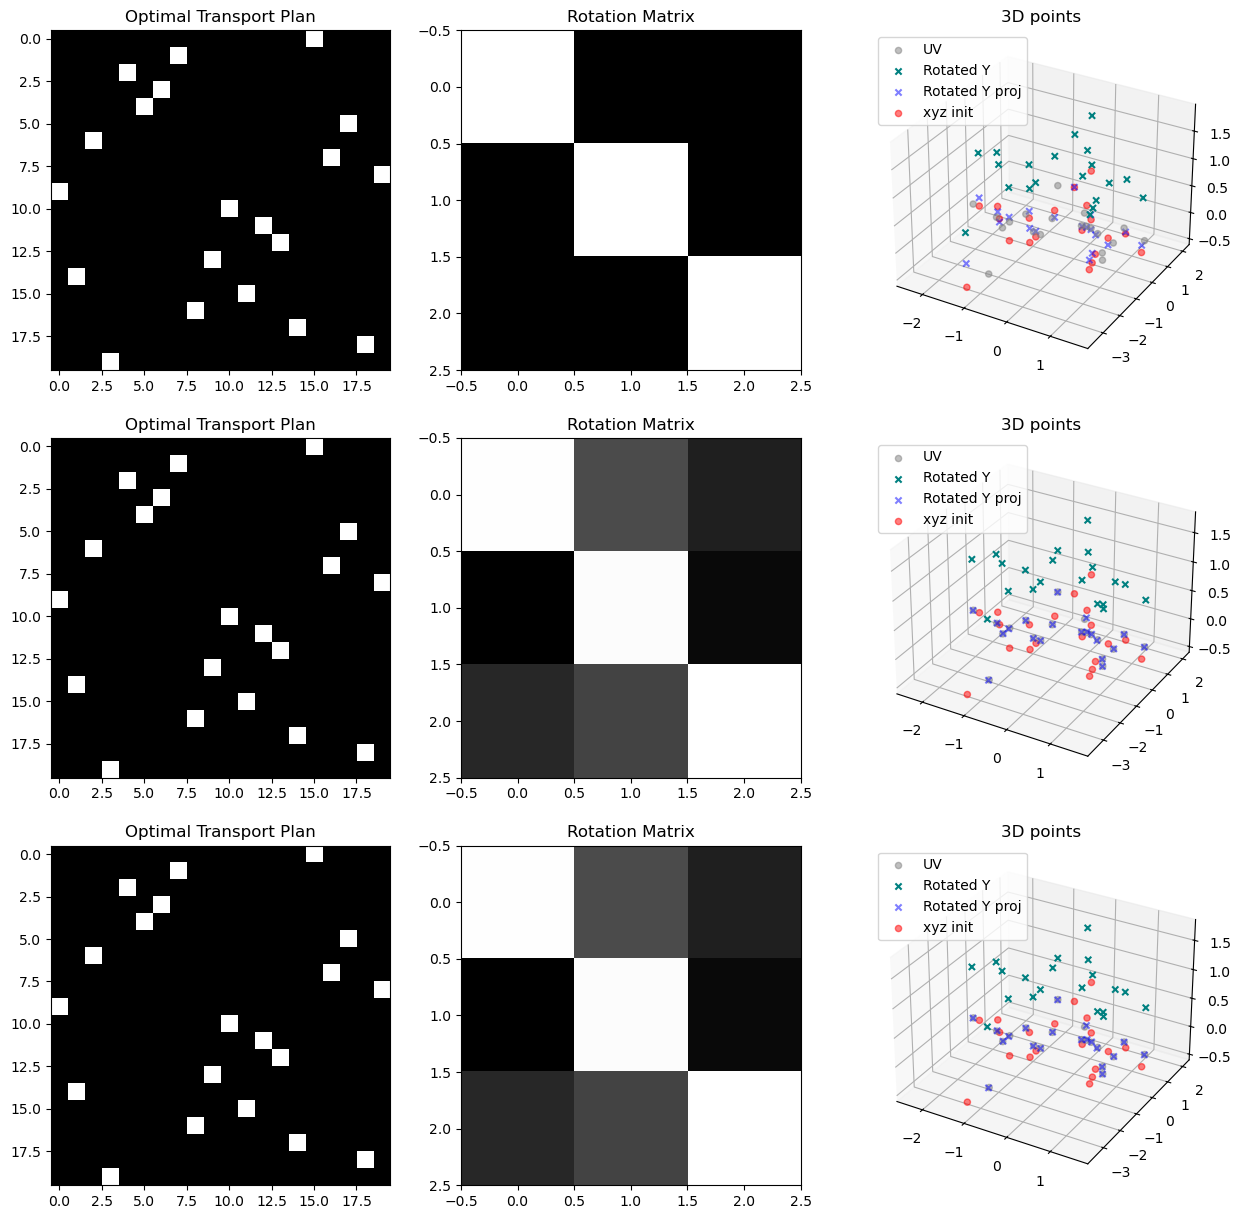

In [580]:
n_pl = min(10, len(logs))
X = UV.numpy()
transport_plans = [log['transport_plan'] for log in logs[:n_pl]]
Ps = [log['R'] for log in logs[:n_pl]]
YR = [log['YR'] for log in logs[:n_pl]]

fig, axes = plt.subplots(1,2)
axes[0].plot([log['cost'] for log in logs], label='EMD')
axes[1].plot([log['point_norm'] for log in logs], label='point norm')
plt.show()


# plot these three
fig, axes = plt.subplots(n_pl, 3, figsize=(15, 5*n_pl), )
for idx in range(len(transport_plans)):
    axes[idx, 0].imshow(transport_plans[idx], cmap='gray')
    axes[idx,0].set_title('Optimal Transport Plan')
    axes[idx,1].imshow(Ps[idx], cmap='gray')
    axes[idx,1].set_title('Rotation Matrix')

    axes[idx, 2].remove()

    # Rotated Y with X in 3D
    ax2 = fig.add_subplot(n_pl, 3, 3 * idx + 3, projection='3d')
    alpha = 0.5
    ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray', alpha=alpha)
    ax2.scatter(xs=YR[idx][:, 0], ys=YR[idx][:, 1], zs=YR[idx][:, 2]+1, label='Rotated Y', marker='x', color='teal', alpha=1)
    ax2.scatter(xs=YR[idx][:, 0], ys=YR[idx][:, 1], zs=0, label='Rotated Y proj', marker='x', color='blue', alpha=alpha)
    ax2.scatter(xs=xyz_init[:, 0], ys=xyz_init[:, 1], zs=xyz_init[:, 2], label='xyz init', marker='o', color='red', alpha=alpha)
    ax2.set_title('3D points')
    ax2.legend()




In [581]:
np.allclose((transport_plan @ YR[-1].numpy())[:,:2], UV, atol=1)

True

In [582]:
np.allclose((transport_plan @ xyz_init.numpy() @ rotation.numpy())[:,:2], UV, atol=1)

True